In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import math

class ConditionalDiffusionModel(nn.Module):
    def __init__(self, input_size, weight_template_size):
        super(ConditionalDiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_size + weight_template_size, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, input_size)

    def forward(self, x, condition):
        # Concatenate the image and weight template (condition)
        x = torch.cat((x, condition), dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [2]:
class DiffusionTrainer:
    def __init__(self, model, timesteps=1000, schedule='linear', patience=10):
        self.model = model
        self.timesteps = timesteps

        self.schedule = schedule
        self.patience = patience
        # self.beta = np.linspace(1e-4, 0.02, timesteps)  # Linear schedule
        if schedule == 'linear':
            self.beta = np.linspace(1e-4, 0.02, timesteps)  # Linear schedule
        elif schedule == 'cosine':
            self.beta = self.cosine_beta_schedule(timesteps)  # Cosine schedule
        elif schedule == 'sigmoid':
            self.beta = self.sigmoid_beta_schedule(timesteps)  # Sigmoid schedule
        elif schedule == 'exponential':
            self.beta = self.exponential_beta_schedule(timesteps)  # Exponential schedule
        else:
            raise ValueError(f"Unknown beta schedule: {schedule}")
        
        self.alpha = 1 - self.beta
        self.alpha_bar = np.cumprod(self.alpha)
    
    def cosine_beta_schedule(self, timesteps, s=0.008):
        """
        Cosine scheduling
        """
        steps = timesteps + 1
        x = np.linspace(0, timesteps, steps)
        alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return np.clip(betas, 1e-4, 0.02)
    
    def sigmoid_beta_schedule(self, timesteps, start=-3, end=3, steps=1000):
        """
        Sigmoid scheduling
        """
        betas = []
        for i in np.linspace(start, end, steps):
            betas.append(1 / (1 + math.exp(-i)))
        return np.array(betas)
    
    def exponential_beta_schedule(self, timesteps, decay=0.999):
        """
        Exponential scheduling
        """
        betas = []
        beta = 1e-4
        for _ in range(timesteps):
            betas.append(beta)
            beta *= decay
        return np.array(betas)

    def sample_noise(self, shape):
        return torch.randn(shape)

    def q_sample(self, x_start, t):
        noise = self.sample_noise(x_start.shape).to(x_start.device)
        
        # Correct broadcasting for alpha_bar_t
        alpha_bar_t = torch.tensor(self.alpha_bar[t], dtype=torch.float32, device=x_start.device).view(-1, 1)
        
        return torch.sqrt(alpha_bar_t) * x_start + torch.sqrt(1 - alpha_bar_t) * noise

    def loss_fn(self, x_noisy, t, x_start, condition):
        predicted_x_start = self.model(x_noisy, condition)
        return F.mse_loss(predicted_x_start, x_start)

    def train(self, data_loader, optimizer, weight_templates, num_epochs=100):
        best_loss = float('inf')
        epochs_without_improvement = 0

        for epoch in range(num_epochs):
            epoch_loss = 0.0
            for i, (x_start, idx) in enumerate(data_loader):
                t = torch.randint(0, self.timesteps, (x_start.size(0),)).to(x_start.device)
                x_noisy = self.q_sample(x_start, t)
                condition = weight_templates[idx].to(x_start.device)

                loss = self.loss_fn(x_noisy, t, x_start, condition)
                epoch_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            epoch_loss /= len(data_loader)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

            if epoch_loss < best_loss:
                best_loss = epoch_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= self.patience:
                    print("Early stopping triggered.")

                    break

# Input image size and weight template size
input_size = 150 * 150 * 1  # Example for 64x64 RGB images
weight_template_size = 128  # Assuming your weight template is 256-dimensional

# Initialize model
model = ConditionalDiffusionModel(input_size, weight_template_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
trainer = DiffusionTrainer(model, timesteps=1000, schedule='sigmoid', patience=10)

# Example: Data loading (assume images and weight templates are in NumPy format)
# Here `images.npy` contains the training images and `weight_templates.npy` contains the corresponding weight templates.

import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Load images and weight templates
images = np.load("/Users/gvssriram/Desktop/projects-internship/PalmGenAI/Datasets/IITD Palmprint V1/Preprocessed/Left/X_train.npy")  # Shape: (N, 64, 64, 3)
weight_templates = np.load("/Users/gvssriram/Desktop/projects-internship/PalmGenAI/Datasets/IITD Palmprint V1/Preprocessed/Left/X_train_pca_128.npy")  # Shape: (N, 256)

# Preprocessing
images = torch.tensor(images).float().view(-1, input_size)  # Flatten images
weight_templates = torch.tensor(weight_templates).float()

# Create dataset and dataloader
dataset = TensorDataset(images, torch.arange(images.shape[0]))  # Pass indices for weight templates
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Train the model
trainer.train(data_loader, optimizer, weight_templates, num_epochs=500)


Epoch [1/500], Loss: 0.1734
Epoch [2/500], Loss: 0.1287
Epoch [3/500], Loss: 0.0883
Epoch [4/500], Loss: 0.0669
Epoch [5/500], Loss: 0.0504
Epoch [6/500], Loss: 0.0338
Epoch [7/500], Loss: 0.0247
Epoch [8/500], Loss: 0.0220
Epoch [9/500], Loss: 0.0215
Epoch [10/500], Loss: 0.0215
Epoch [11/500], Loss: 0.0214
Epoch [12/500], Loss: 0.0214
Epoch [13/500], Loss: 0.0213
Epoch [14/500], Loss: 0.0213
Epoch [15/500], Loss: 0.0213
Epoch [16/500], Loss: 0.0212
Epoch [17/500], Loss: 0.0212
Epoch [18/500], Loss: 0.0210
Epoch [19/500], Loss: 0.0210
Epoch [20/500], Loss: 0.0210
Epoch [21/500], Loss: 0.0210
Epoch [22/500], Loss: 0.0209
Epoch [23/500], Loss: 0.0209
Epoch [24/500], Loss: 0.0209
Epoch [25/500], Loss: 0.0207
Epoch [26/500], Loss: 0.0206
Epoch [27/500], Loss: 0.0207
Epoch [28/500], Loss: 0.0207
Epoch [29/500], Loss: 0.0206
Epoch [30/500], Loss: 0.0204
Epoch [31/500], Loss: 0.0205
Epoch [32/500], Loss: 0.0203
Epoch [33/500], Loss: 0.0204
Epoch [34/500], Loss: 0.0201
Epoch [35/500], Loss: 0

In [3]:
class DiffusionSampler:
    def __init__(self, model, timesteps=1000):
        self.model = model
        self.timesteps = timesteps
        self.beta = np.linspace(1e-4, 0.02, timesteps)  # Linear schedule
        self.alpha = 1 - self.beta
        self.alpha_bar = np.cumprod(self.alpha)

    def p_sample(self, x, t, condition):
        predicted_x_start = self.model(x, condition)
        alpha_bar_t = torch.tensor(self.alpha_bar[t], dtype=torch.float32, device=x.device)
        alpha_bar_t_prev = torch.tensor(self.alpha_bar[t-1], dtype=torch.float32, device=x.device) if t > 0 else torch.tensor(1.0, dtype=torch.float32, device=x.device)

        noise = torch.randn_like(x)
        return predicted_x_start * torch.sqrt(alpha_bar_t_prev) + noise * torch.sqrt(1 - alpha_bar_t_prev)

    def sample(self, condition, img_shape=(150, 150, 1)):
        x = torch.randn((1, np.prod(img_shape))).to(condition.device)
        for t in reversed(range(self.timesteps)):
            x = self.p_sample(x, t, condition)
        return x.view(img_shape)

# Initialize sampler
sampler = DiffusionSampler(model)

# Load weight templates for the user
user_weight_template = weight_templates[0]  # Shape: (256,)
user_weight_template = torch.tensor(user_weight_template).float().unsqueeze(0)

# Generate deepfake
generated_image = sampler.sample(user_weight_template)
generated_image = generated_image.detach().cpu().numpy()

# Reshape to original image dimensions and save or display
generated_image = generated_image.reshape(150, 150, 1)


/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_7243/82786077.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  user_weight_template = torch.tensor(user_weight_template).float().unsqueeze(0)


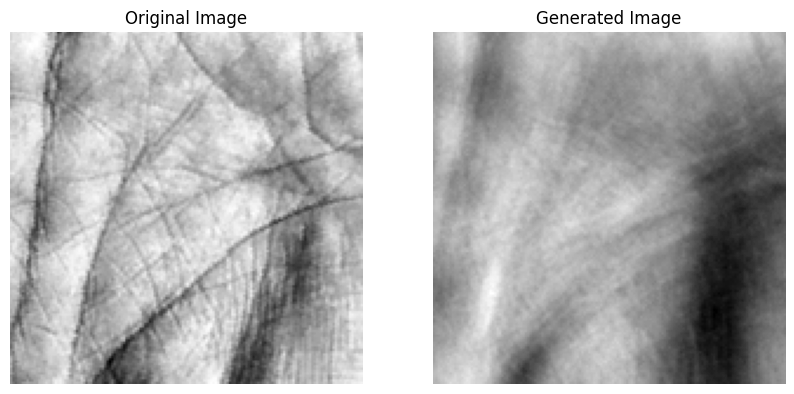

In [4]:
import matplotlib.pyplot as plt

# Displaying the original and generated images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original image
axes[0].imshow(images[0].reshape(150, 150), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# Generated image
axes[1].imshow(generated_image.reshape(150, 150), cmap='gray')
axes[1].set_title("Generated Image")
axes[1].axis('off')

# Show the plot
plt.show()